# Chap 11 - Ex2: classify customer into different groups based on data ageinc_g.csv (Age, Income, Gender)
## Use KMeansClustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)

In [2]:
customer = pd.read_csv('Data/ageinc_g.csv', index_col = 0)
customer

,income,age,gender
0,101743,58,Female
1,49597,27,Female
2,36517,52,Male
3,33223,49,Male
4,72994,53,Female
...,...,...,...
995,70615,29,Female
996,95102,41,Female
997,42203,35,Male
998,16975,31,Female


In [3]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   income  1000 non-null   int64 
 1   age     1000 non-null   int64 
 2   gender  1000 non-null   object
dtypes: int64(2), object(1)
memory usage: 31.2+ KB


In [4]:
customer.describe()

,income,age
count,1000.00000,1000.000000
mean,80116.81800,39.410000
std,39262.33567,10.976811
min,0.00000,18.000000
25%,46402.25000,30.000000
50%,78993.50000,39.000000
75%,114810.50000,49.000000
max,179294.00000,63.000000


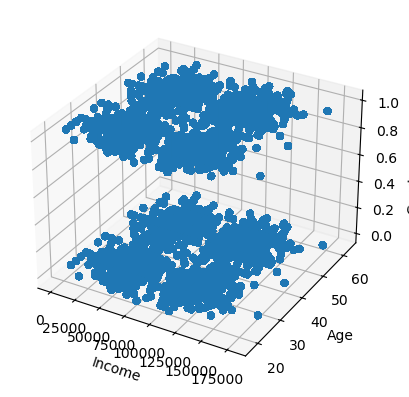

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(customer['income'], customer['age'], pd.get_dummies(customer['gender'], drop_first = True).astype(int))
ax.set_xlabel('Income')
ax.set_ylabel('Age')
ax.set_zlabel('Gender_Female')
plt.show()

## <span style = 'color:yellow'> Check normal distribution and outliers of Income and Age

Normality test of Income: ShapiroResult(statistic=0.95244171092576, pvalue=1.8452768011280746e-17)
Normality test of Age: ShapiroResult(statistic=0.9490401537479766, pvalue=4.221272310083379e-18)



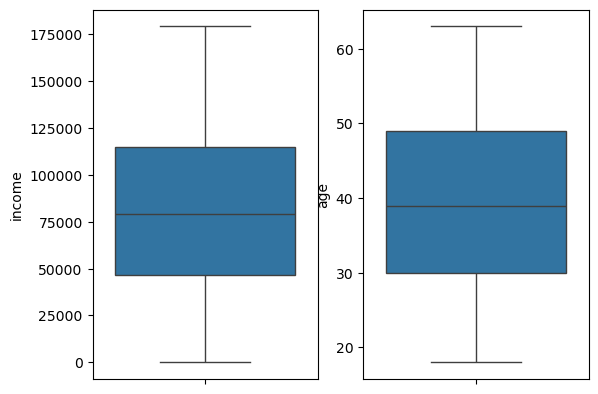


Age and Income are not normally distributed, but do not have outliers => can use MinMaxScaler


In [6]:
from scipy.stats import shapiro
print(f'Normality test of Income: {shapiro(customer['income'])}')
print(f'Normality test of Age: {shapiro(customer['age'])}')
print()

plt.subplot(1,2,1)
sbn.boxplot(data = customer, y = 'income')
plt.subplot(1,2,2)
sbn.boxplot(data = customer, y = 'age')
plt.show()

print('\nAge and Income are not normally distributed, but do not have outliers => can use MinMaxScaler')

## <span style = 'color:yellow'> Find optimal K using Elbow Method and Silhoutte Score

Silhouette score for k = 2: 0.6214218944532653
Silhouette score for k = 3: 0.48891273186035566
Silhouette score for k = 4: 0.3979088492710091
Silhouette score for k = 5: 0.4318111512498591
Silhouette score for k = 6: 0.46761786341070055
Silhouette score for k = 7: 0.47257538142942634
Silhouette score for k = 8: 0.5051715914845936
Silhouette score for k = 9: 0.48341247820751093


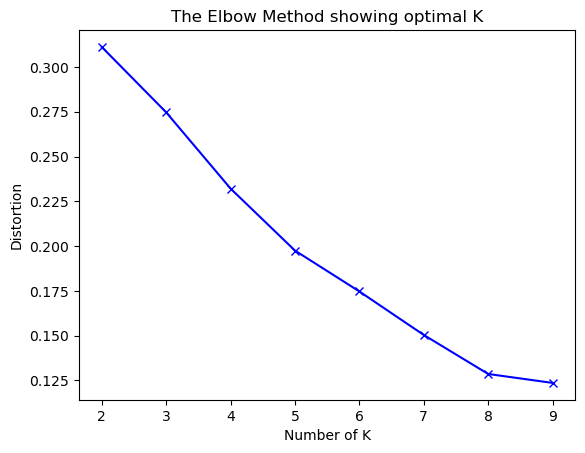


Choose K = 8


In [8]:
#Use elbow method to find optimal K

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
import math

distortions = []
k_nums = range(2,10)

for k in k_nums:
    kmeans_pipe = Pipeline([
        ('OneHotEncoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), ['gender']), remainder='passthrough')),
        ('MinMaxScaler', MinMaxScaler()),
        ('KMeansModel', KMeans(n_clusters = k, random_state = 2))
    ])
    kmeans_pipe.fit(customer)
    customer_scaled = (
        pd.DataFrame(kmeans_pipe[:-1].transform(customer)) #Transform original data with onehotencoder and MinMaxScaler
        .pipe(lambda df: df.set_axis(kmeans_pipe.named_steps['OneHotEncoder'].get_feature_names_out(), axis =1))
    )
     
    centroids = kmeans_pipe.named_steps['KMeansModel'].cluster_centers_
    sum_var = sum(np.min(cdist(customer_scaled, centroids, 'euclidean'), axis = 1)) / customer.shape[0]
    distortions.append(sum_var)
    labels = kmeans_pipe.named_steps['KMeansModel'].labels_
    print(f'Silhouette score for k = {k}: {silhouette_score(customer_scaled, labels)}')

plt.plot(k_nums, distortions, 'bx-')
plt.xlabel('Number of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing optimal K')
plt.show()

print('\nChoose K = 8')

## <span style = 'color:yellow'> Build official KMeansClustering with K = 8

Coordinate of all centroids:
 [[     1.          43186.58536585     29.81300813]
 [     0.         115349.49074074     50.50925926]
 [     1.         115739.81203008     28.7518797 ]
 [     0.          43920.33870968     29.48387097]
 [     1.          47296.79166667     49.45833333]
 [     1.         117313.4            48.1037037 ]
 [     0.          45797.90441176     49.23529412]
 [     0.         113769.97520661     30.43801653]]

     gender_Male    income   age  Group
0            0.0  101743.0  58.0      1
1            0.0   49597.0  27.0      3
2            1.0   36517.0  52.0      4
3            1.0   33223.0  49.0      4
4            0.0   72994.0  53.0      6
..           ...       ...   ...    ...
995          0.0   70615.0  29.0      3
996          0.0   95102.0  41.0      1
997          1.0   42203.0  35.0      0
998          0.0   16975.0  31.0      3
999          1.0  123857.0  44.0      5

[1000 rows x 4 columns]



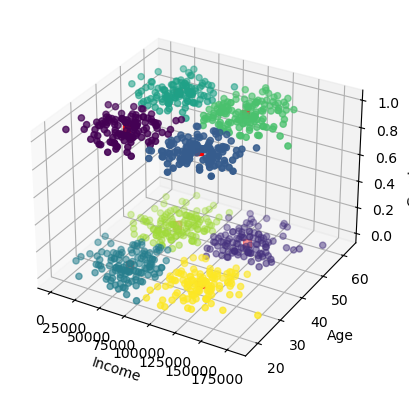

In [9]:
kmeans_pipe = Pipeline([
    ('OneHotEncoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), ['gender']), remainder='passthrough')),
    ('MinMaxScaler', MinMaxScaler()),
    ('KMeansModel', KMeans(n_clusters = 8, random_state = 2))
])

kmeans_pipe.fit(customer)

centroids = kmeans_pipe.named_steps['KMeansModel'].cluster_centers_
centroids = kmeans_pipe.named_steps['MinMaxScaler'].inverse_transform(centroids) #Convert centroid coordinate back to original scale
labels = kmeans_pipe.named_steps['KMeansModel'].labels_

print('Coordinate of all centroids:\n', centroids)

customer_group = (
    pd.DataFrame(kmeans_pipe.named_steps['OneHotEncoder'].transform(customer))
    .pipe(lambda df: df.set_axis(['gender_Male', 'income', 'age'], axis = 1)) 
    .assign(Group = labels)
)

print()
print(customer_group)
print()

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(centroids[:,1], centroids[:,2], centroids[:,0], marker = 's', s = 30, color = 'red')
ax.scatter(customer_group['income'], customer_group['age'], customer_group['gender_Male'], c = customer_group['Group'])
ax.set_xlabel('Income')
ax.set_ylabel('Age')
ax.set_zlabel('Gender_Male')
plt.show()

# <span style = 'color:yellow'> Report clustering results

In [47]:
# Method 1
for group in customer_group['Group'].unique():
    print(f'\n=============== Customer group {group} =========================\n')
    data = customer_group[customer_group['Group'] == group]
    print(f'n_observations: {data.shape[0]}\n')
    for col_name in data.columns[:-1]:
        if col_name == 'gender_Male':
            print(f'{data[col_name].value_counts().to_frame().reset_index()}')
            print()
        else:
            print(f'{col_name}: {np.min(data[col_name])} ~ {np.median(data[col_name])} ~ {np.max(data[col_name])}')
            print()


=============== Customer group 1 =========================

n_observations: 108

   gender_Male  count
0          0.0    108

income: 79721.0 ~ 112600.0 ~ 175497.0

age: 41.0 ~ 49.5 ~ 62.0


=============== Customer group 3 =========================

n_observations: 124

   gender_Male  count
0          0.0    124

income: 0.0 ~ 46850.0 ~ 79360.0

age: 18.0 ~ 30.0 ~ 39.0


=============== Customer group 4 =========================

n_observations: 120

   gender_Male  count
0          1.0    120

income: 3384.0 ~ 47699.0 ~ 84364.0

age: 40.0 ~ 49.5 ~ 61.0


=============== Customer group 6 =========================

n_observations: 136

   gender_Male  count
0          0.0    136

income: 0.0 ~ 47282.5 ~ 78534.0

age: 40.0 ~ 49.0 ~ 63.0


=============== Customer group 0 =========================

n_observations: 123

   gender_Male  count
0          1.0    123

income: 0.0 ~ 44760.0 ~ 78654.0

age: 19.0 ~ 30.0 ~ 39.0


=============== Customer group 7 =========================

n_obs

Number of numeric fields: 2

All numeric fields: ['income', 'age']



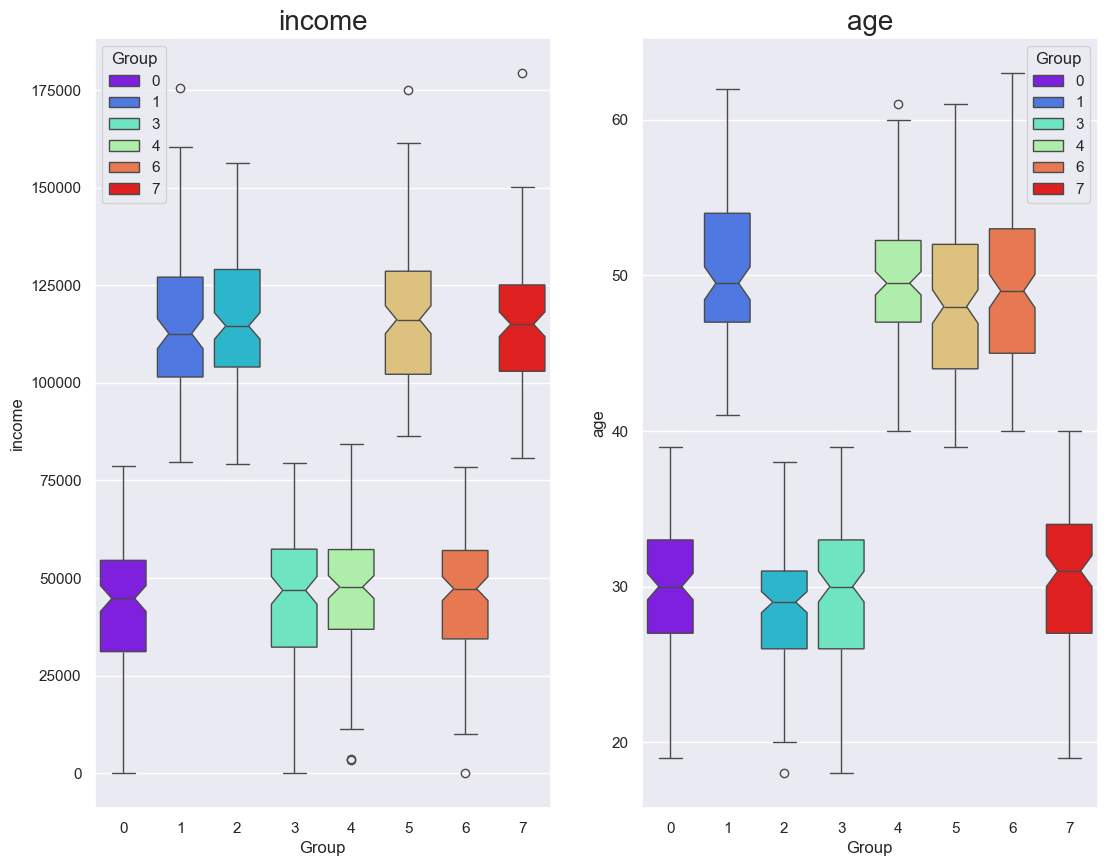


-----------------------------------------------------------------------------------------------------------------------------

Number of categorical fields: 1

All categorical fields: ['gender_Male']



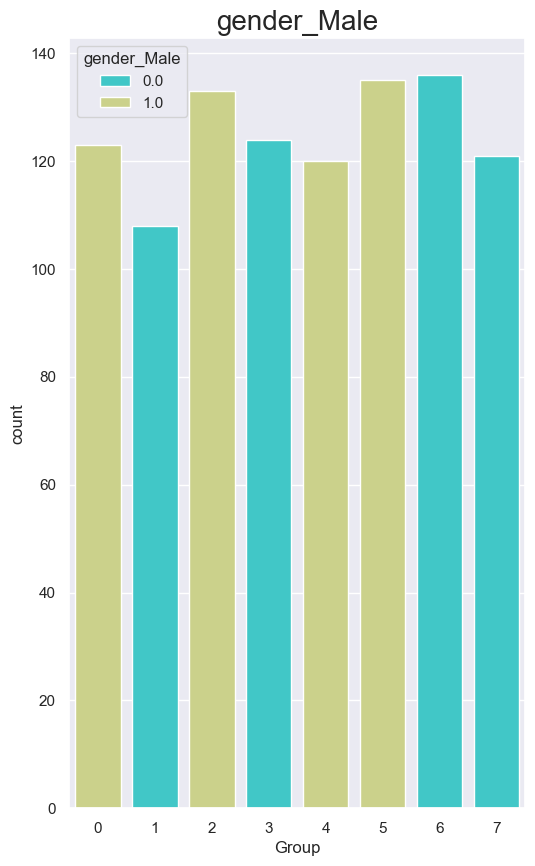

In [49]:
# Method 3:
data_group = customer_group.copy()

numeric_cols = ['income', 'age']
categ_cols = ['gender_Male']

##### Function building ##############

def boxplot_numeric(df, numeric_cols, figsize=(20, 10), groups = None):
    col = 3
    if (len(numeric_cols) % 3) == 0:
        row = len(numeric_cols) // 3
    else:
        row = (len(numeric_cols) // 3) + 1
    '''
    numeric_cols: list các tên cột biến định lượng
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of numeric fields: {len(numeric_cols)}')
    print()
    print(f'All numeric fields: {numeric_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.boxplot(data = df, x = groups, y = numeric_cols[i-1], notch = True, hue = groups, palette = 'rainbow')
        plt.title(numeric_cols[i-1], size = 20)
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break
    plt.show()


def countplot_categ(df, categ_cols, figsize=(20, 10), groups = None):
    col = 3
    if (len(categ_cols) % 3) == 0:
        row = len(categ_cols) // 3
    else:
        row = (len(categ_cols) // 3) + 1
    '''
    categ_cols: list các tên cột biến định tính
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of categorical fields: {len(categ_cols)}')
    print()
    print(f'All categorical fields: {categ_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(categ_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.countplot(data = df, x = groups, hue = categ_cols[i-1], palette = 'rainbow')
        plt.title(categ_cols[i-1], size = 20)
      except:
        print('Error {}'.format(categ_cols[i-1]))
        break
    plt.show()

## Draw
sbn.set_theme(style ='darkgrid')
boxplot_numeric(data_group, numeric_cols, groups = data_group.iloc[:,-1])
print('\n-----------------------------------------------------------------------------------------------------------------------------\n')
countplot_categ(data_group, categ_cols, groups = data_group.iloc[:,-1])